In [1]:
import pandas as pd
import numpy as np

f1 = 'Fare_Card_History_for_Metropolitan_Transportation_Authority__MTA___Beginning_2010.csv'
f2 = 'MTA_Customer_Feedback_Data__Beginning_2014.csv'

In [2]:
fare = pd.read_csv(f1)
feed = pd.read_csv(f2)

In [3]:
feed.columns

Index([u'Agency', u'Commendation or Complaint', u'Subject Matter',
       u'Subject Detail', u'Issue Detail', u'Year', u'Quarter',
       u'Branch/Line/Route'],
      dtype='object')

In [4]:
feed[feed['Commendation or Complaint']=='Complaint']['Issue Detail'].value_counts()

Late / Delay                                17302
Rude / Inappropriate Language               14076
Flagging / Failed To Stop                   10124
Improper Function/Needs Repair/Damaged       8878
Reckless Driving                             8505
Other                                        8246
Late / Delay Past                            7005
Failure To Make Scheduled Stop               6724
Not regulating service properly              5030
Not Helpful                                  4979
Closed Door Before Customer Could Board      4682
Not Working / Out of Service                 4474
Crowding                                     3948
Add More / Not Enough                        3614
A/C Not Available                            3454
Abandoned Customer at Station/Stop           3330
Late / Delay Current                         2939
Litter / Garbage / Debris                    2814
Pricing / Payment / Billing Error            2728
No Announcement / Messages - Audio           2645


In [5]:
#These complaints seem to be the most addressable with increased funding
bad = ['Late / Delay','Improper Function/Needs Repair/Damaged','Crowding','A/C Not Available']

In [6]:
fare['Total'] = fare['Full Fare']
cols = list(fare.columns)
cols = cols[5:]
for col in cols:
    fare['Total'] = fare['Total']+fare[col]
fare['Quarter'] = [int(x[:2])/4 + 1 for x in fare['From Date']]
fare['Year'] = [int(x[-4:]) for x in fare['From Date']]
fare = fare[['Total','Quarter','Year']].groupby(['Year','Quarter']).sum().reset_index()

In [7]:
feed['Commendation'] = [1 if x=='Commendation' else 0 for x in feed['Commendation or Complaint']]
feed['Complaint'] = [1 if x=='Complaint' else 0 for x in feed['Commendation or Complaint']]
for complaint in bad:
    feed[complaint] = [1 if x==complaint else 0 for x in feed['Issue Detail']]

feed = feed[['Commendation','Complaint','Year','Quarter']+bad].groupby(['Year','Quarter']).sum().reset_index()

In [8]:
join = feed.merge(fare,on=['Year','Quarter'])

In [9]:
join.head()

,Year,Quarter,Commendation,Complaint,Late / Delay,Improper Function/Needs Repair/Damaged,Crowding,A/C Not Available,Total
0,2014,3,327,5899,304,206,83,55,1146595464
1,2014,4,359,6466,360,239,90,10,119474452
2,2015,1,411,8365,309,307,190,2,662022698
3,2015,2,433,8876,310,321,256,68,1023233532
4,2015,3,443,8497,307,339,193,99,830594546


In [10]:
f3 = 'Metropolitan_Transportation_Authority__MTA__Performance_Indicators_per_Agency__Beginning_2008.csv'
perf = pd.read_csv(f3)

In [11]:
perf = perf[perf['Indicator Name']== 'Subway Wait Assessment ']
perf = perf[['Period Year','Period Month','Monthly Actual']]
perf.columns = ['Year','Month','Wait']
perf['Quarter'] = [x/4 + 1 for x in perf['Month']]
perf = perf[['Wait','Quarter','Year']].groupby(['Year','Quarter']).sum().reset_index()

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
full = join['Total']/10000000000
comp = (join[bad[2]]/join['Commendation'])


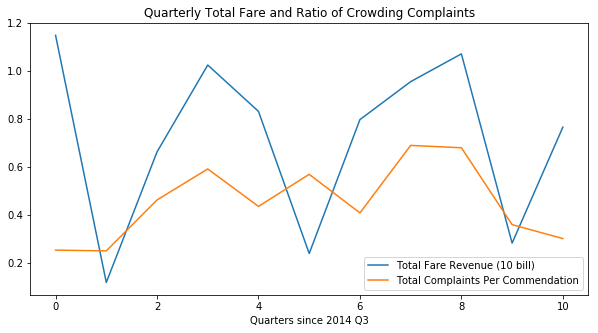

In [21]:
plt.figure(figsize=(10,5))
plt.plot(range(len(full)),full)
plt.plot(range(len(full)),comp)
plt.title('Quarterly Total Fare and Ratio of ' + bad[2] + ' Complaints')
plt.xlabel('Quarters since 2014 Q3')
plt.legend(['Total Fare Revenue (10 bill)','Total Complaints Per Commendation'])
plt.show()

It takes time for budgets, so let's try lagging and just check correlations

In [46]:
import copy
temp = copy.deepcopy(join)
temp = temp[['Total']+bad]
for col in bad:
    temp[col] = temp[col]
print 'Complaints unscaled'

Complaints unscaled


In [47]:
len(temp)

11

In [48]:
for i in range(4):
    print 'Total Revenue Lagged ' + str(i) + ' quarters'
    print 'Correlation to total revenue \n'
    print temp.corr(method='pearson').iloc[0]
    print '\n'
    temp['Total'] = temp['Total'].shift(1)

Total Revenue Lagged 0 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                             -0.197032
Improper Function/Needs Repair/Damaged   -0.124607
Crowding                                  0.123953
A/C Not Available                         0.336275
Name: Total, dtype: float64


Total Revenue Lagged 1 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                              0.103115
Improper Function/Needs Repair/Damaged   -0.057238
Crowding                                  0.041197
A/C Not Available                         0.267334
Name: Total, dtype: float64


Total Revenue Lagged 2 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                              0.195696
Improper Function/Needs Repair/Damaged    0.337634
Crowding                                 -0.184065
A/C Not Available                    

In [37]:
temp = copy.deepcopy(join)
temp = temp[['Total']+bad]
for col in bad:
    temp[col] = temp[col]/join['Commendation']
print 'Complaints scaled by commendations'

Complaints scaled by commendations


In [39]:
for i in range(4):
    print 'Total Revenue Lagged ' + str(i) + ' quarters'
    print 'Correlation to total revenue \n'
    print temp.corr(method='pearson').iloc[0]
    print '\n'
    temp['Total'] = temp['Total'].shift(1)

Total Revenue Lagged 0 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                             -0.240638
Improper Function/Needs Repair/Damaged   -0.125828
Crowding                                  0.328205
A/C Not Available                         0.367249
Name: Total, dtype: float64


Total Revenue Lagged 1 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                              0.214469
Improper Function/Needs Repair/Damaged    0.035563
Crowding                                  0.068443
A/C Not Available                         0.279794
Name: Total, dtype: float64


Total Revenue Lagged 2 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                              0.180914
Improper Function/Needs Repair/Damaged    0.361616
Crowding                                 -0.585998
A/C Not Available                    

In [ ]:
temp = copy.deepcopy(join)
temp = temp[['Total']+bad]
for col in bad:
    temp[col] = temp[col]/join['Complaints']
print 'Complaints scaled by complaints total'

In [40]:
for i in range(4):
    print 'Total Revenue Lagged ' + str(i) + ' quarters'
    print 'Correlation to total revenue \n'
    print temp.corr(method='pearson').iloc[0]
    print '\n'
    temp['Total'] = temp['Total'].shift(1)

Total Revenue Lagged 0 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                             -0.655743
Improper Function/Needs Repair/Damaged   -0.303067
Crowding                                  0.180305
A/C Not Available                         0.197426
Name: Total, dtype: float64


Total Revenue Lagged 1 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                              0.932380
Improper Function/Needs Repair/Damaged   -0.010631
Crowding                                  0.596676
A/C Not Available                         0.437707
Name: Total, dtype: float64


Total Revenue Lagged 2 quarters
Correlation to total revenue 

Total                                     1.000000
Late / Delay                             -0.579737
Improper Function/Needs Repair/Damaged    0.254336
Crowding                                 -0.765455
A/C Not Available                    

In [41]:
join2 = join.merge(perf,on=['Year','Quarter'])

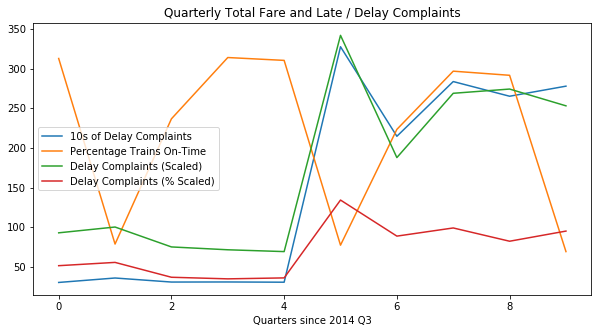

In [62]:
plt.figure(figsize=(10,5))
plt.plot(range(len(join2)),join2[bad[0]]/10)
plt.plot(range(len(join2)),join2['Wait'])
plt.plot(range(len(join2)),100*join2[bad[0]]/join2['Commendation'])
plt.plot(range(len(join2)),1000*join2[bad[0]]/join2['Complaint'])
plt.title('Quarterly Total Fare and ' + bad[0] + ' Complaints')
plt.xlabel('Quarters since 2014 Q3')
plt.legend(['10s of Delay Complaints','Percentage Trains On-Time','Delay Complaints (Scaled)','Delay Complaints (% Scaled)'])
plt.show()